In [61]:
%pip install numpy
%pip install pandas
%pip install matplotlib

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
# reading and filtering dataset 2 bankrupcty data
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)
BNK_DATA = pd.read_csv(
    './data/Qualitative_Bankruptcy.data.txt', 
    sep=',',
    names=['industrial risk', 'management risk', 'financial flexibility', 'credibility', 'competitiveness', 'operating risk', 'class'])

# mapping data positive: 1, average: 0.5, negative: 0 ... classification not bankrupt: 0, bankrupt: 1
for col in BNK_DATA:
    BNK_DATA[col] = BNK_DATA[col].replace({
        'P': 1, 
        'A': 0, 
        'N': -1,
        'NB': 0,
        'B': 1})

print(BNK_DATA)
BNK_DATA = BNK_DATA.to_numpy()

# shuffling bnk_data across axis 1 before making train validation test splits
np.random.shuffle(BNK_DATA)

n, d = BNK_DATA.shape
# adding bi# adding ones column for bias
BNK_DATA = np.column_stack((np.ones(n),BNK_DATA))


# 60:20:20 split
BNK_TRAIN = BNK_DATA[:150, :]           # 150 samples for training
BNK_VALIDATION = BNK_DATA[150:200, :]   # 50 samples for validation / hyperparameter tuning
BNK_TEST = BNK_DATA[200:, :]            # 50 samples for testing
BNK_TRAIN

     industrial risk  management risk  financial flexibility  credibility  competitiveness  operating risk  class
0                  1                1                      0            0                0               1      0
1                 -1               -1                      0            0                0              -1      0
2                  0                0                      0            0                0               0      0
3                  1                1                      1            1                1               1      0
4                 -1               -1                      1            1                1              -1      0
..               ...              ...                    ...          ...              ...             ...    ...
245               -1               -1                      0           -1               -1              -1      1
246                1               -1                     -1           -1               

array([[ 1.,  1.,  1., ...,  1.,  1.,  0.],
       [ 1.,  0.,  1., ...,  0.,  1.,  0.],
       [ 1., -1., -1., ..., -1.,  0.,  1.],
       ...,
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1., -1., ...,  0.,  0.,  1.],
       [ 1.,  0., -1., ..., -1., -1.,  1.]])

In [63]:
# bankrupcty dataset stats
n, d = BNK_DATA[:, 1:-1].shape
print(f'instances: {n}\nfeatures: {d}\nmean: {np.mean(BNK_DATA[:,1:7].flatten())}\nmedian: {np.median(BNK_DATA[:,1:7].flatten())}')
print(f'bankrupt: {sum(BNK_DATA[:, 7])}\nnot bankrupt: {250-sum(BNK_DATA[:, 7])}')

instances: 250
features: 6
mean: -0.12666666666666668
median: 0.0
bankrupt: 107.0
not bankrupt: 143.0


In [64]:
# logistic squishification function
logistic = lambda z : 1. / (1 + np.exp(-z))

#cross entropy loss function 
# w: weight column vector   D x 1
# x: feature matrix         N x D
# y: expected labels        N x 1
# yh: predicted labels       N x 1
# yh = x @ w
def loss(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    return np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 

# gradient descent
# w: weight column vector   D x 1
# x: feature matrix         N x D
# y: expected labels        N x 1
# yh: predicted labels       N x 1
def gradient(w, x, y):
    n, d = x.shape
    yh = logistic(np.dot(x, w))
    return np.dot(x.T, yh - y) / n

def fit(x, y, learning_rate: int=0.09, epsilon: int=0.001, max_iters: int=1000, batch_size: int=150):
    n, d = x.shape
    w = np.zeros(d)
    g = np.inf 
    t = 0
    
    num_batches = n // batch_size
    for i in range(0, num_batches, batch_size):
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > epsilon and t < max_iters:
            g = gradient(w, x[i:i+batch_size], y[i:i+batch_size])
            w = w - learning_rate * g 
            t += 1

    return w

def predict(w, x):
    yh = logistic(np.dot(x, w))
    return np.array([round(num, 2) for num in yh])

x = BNK_TRAIN[:, :7]
y = BNK_TRAIN[:, 7]

w = fit(x, y)

In [65]:
# mean squared error for yh_test and y_test
def mse(y, yh):
    return np.sum((y - yh) ** 2) / y.shape[0]

#1 testing model accuracy, loss, mse for test and train splits
x_test = BNK_TEST[:, :7]
y_test = BNK_TEST[:, 7]
yh_test = predict(w, x_test)

x_train = BNK_TRAIN[:, :7]
y_train = BNK_TRAIN[:, 7]
yh_train = predict(w, x_train)

print(f'y_test: yh_test\n{np.column_stack((y_test,yh_test))}')
print(f'loss_test: {loss(x_test,y_test,w)}\nmse_test: {mse(y_test, yh_test)}')
print(f'loss_train: {loss(x_train,y_train,w)}\nmse_train: {mse(y_train, yh_train)}')


y_test: yh_test
[[1.   0.96]
 [1.   1.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.02]
 [1.   1.  ]
 [0.   0.12]
 [0.   0.13]
 [1.   1.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [1.   0.99]
 [1.   0.99]
 [1.   1.  ]
 [0.   0.  ]
 [0.   0.01]
 [0.   0.07]
 [1.   0.99]
 [0.   0.07]
 [0.   0.01]
 [0.   0.12]
 [0.   0.01]
 [0.   0.02]
 [0.   0.  ]
 [1.   1.  ]
 [0.   0.25]
 [0.   0.  ]
 [0.   0.06]
 [0.   0.  ]
 [1.   0.99]
 [0.   0.15]
 [1.   0.99]
 [1.   0.99]
 [0.   0.  ]
 [1.   0.74]
 [0.   0.  ]
 [1.   0.96]
 [0.   0.  ]
 [0.   0.01]
 [1.   0.99]
 [1.   0.99]
 [0.   0.  ]
 [0.   0.02]
 [1.   1.  ]
 [0.   0.05]
 [0.   0.  ]
 [0.   0.01]
 [1.   0.99]
 [0.   0.01]]
loss_test: 0.03419728164903332
mse_test: 0.0044020000000000005
loss_train: 0.023328958817476125
mse_train: 0.0023246666666666667


In [66]:
#2 weights parameters and features
features_weights = {fe:we for fe,we in zip(["industrial risk", "management risk", "financial flexibility", "credibility", "competitiveness", "operating risk"], w[1:])}
print(f'features and their weights:\n{features_weights}')

# the absolute value of the weights for each of the features indicate how sensitive the model is to the particular parameter, 
# for example competitiveness has a relativley larger effect on the bankrupcty / classification as its weight is -2.91
# the sign of the weights indicates which way the parameter sways the classification, - : less bankruptcy risk + ; more bankrupcty risk


features and their weights:
{'industrial risk': -0.10960863630974454, 'management risk': -0.38073033190003547, 'financial flexibility': -1.7004440867260784, 'credibility': -2.0184721231358456, 'competitiveness': -2.910470127193261, 'operating risk': -0.20622939519736752}


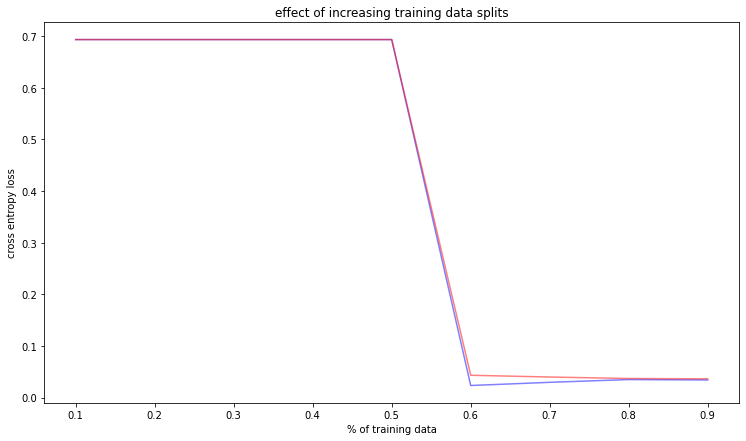

In [67]:
#3 effect of size of training data
plt.rcParams["figure.figsize"] = (12.46, 7)
percents = np.linspace(0.1, 0.9, 9)
losses_train, losses_test = [], []
for p in percents:
    end = int(p * 250)
    start = 250 - end
    x = BNK_DATA[:end, :7]
    y = BNK_DATA[:end, 7]

    w_train = fit(x, y)
    loss_train = loss(x, y, w_train)
    loss_test = loss(BNK_DATA[start:, :7], BNK_DATA[start:, 7], w_train)
    losses_train.append(loss_train)
    losses_test.append(loss_test)

plt.title("effect of increasing training data splits")
plt.xlabel("% of training data")
plt.ylabel("cross entropy loss")
plt.plot(percents, losses_train, 'b', alpha=0.5)
plt.plot(percents, losses_test, 'r-', alpha=0.5)
plt.show()

# the training loss in blue and testing loss in red, seem to both fall very quickly at the 60% training data split
# overall the loss falls with increasing training data which is expected since the model has more data points to
# optimize the loss function but we're not sure why the loss seems to drop so suddenly between the 0.5 and 0.6 splits

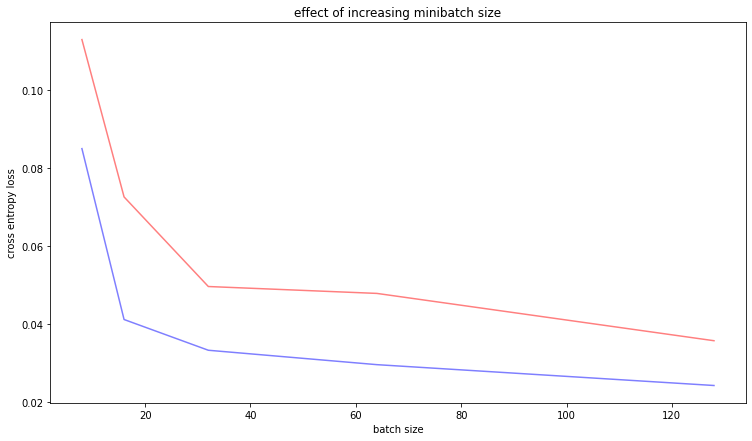

In [68]:
#4 effect of minibatch size
batch_sizes = [8, 16, 32, 64, 128]
losses_train, losses_test = [], []
for b in batch_sizes:

    x_train, y_train = BNK_TRAIN[:, :7], BNK_TRAIN[:, 7]
    x_test, y_test = BNK_TEST[:, :7], BNK_TEST[:, 7]

    w_train = fit(x_train, y_train, batch_size=b)
    loss_train = loss(x_train, y_train, w_train)
    loss_test = loss(x_test, y_test, w_train)
    losses_train.append(loss_train)
    losses_test.append(loss_test)

plt.title("effect of increasing minibatch size")
plt.xlabel("batch size")
plt.ylabel("cross entropy loss")
plt.plot(batch_sizes, losses_train, 'b', alpha=0.5)
plt.plot(batch_sizes, losses_test, 'r-', alpha=0.5)
plt.show()

# it seems like increasing batch size causes the train/test split to converge faster and have a lower loss overall
# after a mini batch size of around 32, the loss for training and testing splits doesnt change much 
# the loss drops off quickly with increasing batch size when starting with small batche sizes like 8 and 16

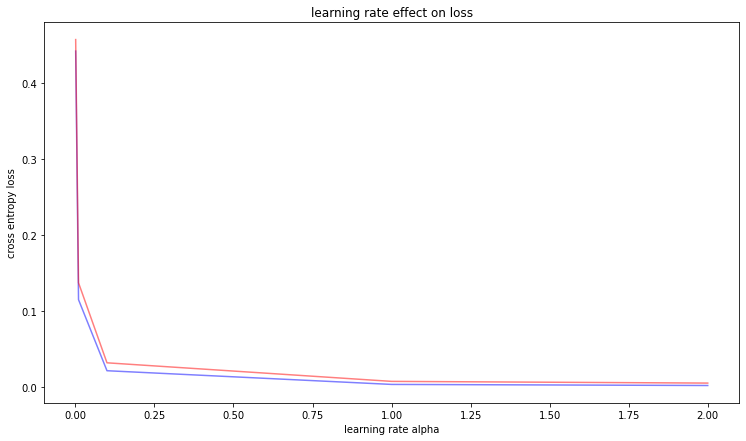

In [69]:
#5 effect of different learning rates
learning_rates = [2, 1, 0.1, 0.01, 0.001]
losses_train, losses_test = [], []
for lr in learning_rates:

    x_train, y_train = BNK_TRAIN[:, :7], BNK_TRAIN[:, 7]
    x_test, y_test = BNK_TEST[:, :7], BNK_TEST[:, 7]

    w_train = fit(x_train, y_train, learning_rate=lr)
    loss_train = loss(x_train, y_train, w_train)
    loss_test = loss(x_test, y_test, w_train)
    losses_train.append(loss_train)
    losses_test.append(loss_test)

plt.title("learning rate effect on loss")
plt.xlabel("learning rate alpha")
plt.ylabel("cross entropy loss")
plt.plot(learning_rates, losses_train, 'b', alpha=0.5)
plt.plot(learning_rates, losses_test, 'r-', alpha=0.5)
plt.show()

# it seems like increasing the learning rate decreasing the overall mean loss of the model, although this seems a bit odd as 
# increasing learning rate should increase the volatility of the loss as the gradient changes the weights more each iteration
# it seems for learning rates > 1 the loss stays relativley stable and low